00 : IMPORTACION DE LIBRERIAS 
___________________________________

In [2]:
#LIBRERIAS PRIMARIAS (BASICO)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

In [3]:
# LIBRERIAS SECUNDARIAS (MODELO PREDCTIVO)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error

In [4]:
# Configuración de librerias para manejo de datos
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
print("Librerías importadas correctamente\n")

Librerías importadas correctamente



PASO 1: CARGA DE DATOS
__________________________

In [5]:
"""
#Esta funcion a continuacion es para para cargar CSV con múltiples intentos y diagnóstico, 
me estaba dando error con pandas, asi que meti una funcion para que forzara la carga de datos
on distintas metodologias, para evitar la omision de datos y explosion de la terminal.
"""


def cargar_csv_seguro(ruta, nombre="archivo"):
    # OPC 1= Carga estándar
    try:
        df = pd.read_csv(ruta, encoding='latin-1')
        print(f" Carga exitosa, todo nitido")
        return df
    except Exception as e:
        print(f"  Error con configuración estándar: {str(e)[:100]}")
    
    # OPC 2= Con manejo de líneas problemáticas
    try:
        df = pd.read_csv(
            ruta,
            encoding='latin-1',
            on_bad_lines='skip',
            engine='python'  # Motor más tolerante
        )
        print(f"   Cargado con motor Python (algunas líneas omitidas)")
        return df
    except Exception as e:
        print(f"   Error con motor Python: {str(e)[:100]}")
    
    # OPC 3= Detectar delimitador automáticamente
    try:
        df = pd.read_csv(
            ruta,
            encoding='latin-1',
            sep=None,  # Detecta automáticamente el delimitador de los datos
            engine='python',
            on_bad_lines='skip'
        )
        print(f"  Carga delimitador automático")
        return df
    except Exception as e:
        print(f"   Error final: {str(e)[:100]}")
        
    # OPC 4=  Carga manual línea por línea (último recurso)
    print(f"  Carga manual...")
    try:
        with open(ruta, 'r', encoding='latin-1') as f:
            lines = f.readlines()
        
        # configuracion de los separadores
        primera_linea = lines[0]
        if ';' in primera_linea:
            sep = ';'
        elif ',' in primera_linea:
            sep = ','
        elif '\t' in primera_linea:
            sep = '\t'
        else:
            sep = ','
        
        df = pd.read_csv(
            ruta,
            encoding='latin-1',
            sep=sep,
            on_bad_lines='skip',
            engine='python'
        )
        return df
    except Exception as e:
        print(f"ERROR MANIN_No se pudo cargar archivo: {e}")
        return None

PASO 2: CARGA DE LOS DATASETS 
______________________

In [24]:
# Cargar dataset DaATA
df_operaciones = cargar_csv_seguro(
    "../datasets/DATA(operaciones_historico_clientes).csv",
    "Operaciones Históricas"
)
# Cargar diccionario de datos
df_diccionario = cargar_csv_seguro(
    "../datasets/diccionario_datos(Sheet1 (2)).csv",
    "Diccionario de Datos"
)



print(f"  Dataframe Operaciones: {df_operaciones.shape[0]:,} filas, {df_operaciones.shape[1]} columnas")
print(f"  Dataframe Diccionario: {df_diccionario.shape[0]:,} filas, {df_diccionario.shape[1]} columnas")
print(f"\n Datos cargados exitosamente")

  Error con configuración estándar: Error tokenizing data. C error: Expected 16 fields in line 30, saw 17

   Cargado con motor Python (algunas líneas omitidas)
  Error con configuración estándar: Error tokenizing data. C error: Expected 1 fields in line 14, saw 4

   Cargado con motor Python (algunas líneas omitidas)
  Dataframe Operaciones: 32,600 filas, 1 columnas
  Dataframe Diccionario: 108 filas, 1 columnas

 Datos cargados exitosamente


PASO 3: EXPLORACIÓN INICIAL
____________________________

In [7]:
def explorar_dataframe(df, nombre):

    print(f"\n GENERALES:") #Este apartado es para la info general del dataframe
    print(f"   Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"   Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    #columna
    print("Columnas")
    for i, col in enumerate(df.columns, 1): 
        tipo = df[col].dtype
        nulos = df[col].isnull().sum()
        pct_nulos = (nulos/len(df))*100
        print(f"   {i:2d}. {col:40s} | {str(tipo):10s} | Nulos: {nulos:5d} ({pct_nulos:5.1f}%)")

        print(f"\n PRIMERAS 3 FILAS:")
        print(df.head(3))

        # Estadísticas de columnas numéricas
    if df.select_dtypes(include=[np.number]).shape[1] > 0:
        print(f"\n ESTADÍSTICAS NUMÉRICAS:")
        print(df.describe())
    
    # Valores nulos
    print(f"\n RESUMEN DE VALORES NULOS:")
    nulos_total = df.isnull().sum().sum()
    pct_nulos_total = (nulos_total / (df.shape[0] * df.shape[1])) * 100
    print(f"   Recuento de totales nulos: {nulos_total:,} ({pct_nulos_total:.2f}% del dataset)")
    
    columnas_con_nulos = df.columns[df.isnull().any()].tolist()
    if columnas_con_nulos:
        print(f"   • Columnas con nulos: {len(columnas_con_nulos)}")
        for col in columnas_con_nulos[:5]:  # Mostrar primeras 5
            nulos = df[col].isnull().sum()
            pct = (nulos / len(df)) * 100
            print(f"     - {col}: {nulos:,} ({pct:.1f}%)")
    
    # Duplicados
    duplicados = df.duplicated().sum()
    print(f"\n FILAS DUPLICADAS: {duplicados:,}")

# Explorar ambos datasets
explorar_dataframe(df_operaciones, "Dataset de Operaciones (DATA)")
explorar_dataframe(df_diccionario, "Diccionario de Datos")

df_clean = df_operaciones.copy() #esto hace una copia para no borrar/modificar el dataframe original
print(f"\n Dataset original: {df_clean.shape[0]:,} filas")

#Manejo de dato duplicados 
duplicados_antes = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()
print(f" Total de duplicados eliminados: {duplicados_antes:,}")

#   normalizacion y visualizacion en nombres de columnas
print(f"\n Normalizando nombres de columnas...")
df_clean.columns = (
    df_clean.columns
    .str.strip()           # Eliminar espacios
    .str.lower()           # Minúsculas
    .str.replace(' ', '_') # Espacios = guiones bajos
    .str.replace('[^a-z0-9_]', '', regex=True)  # Solo alfanuméricos
)
print(f" Columnas normalizadas: {list(df_clean.columns)}")

#Convertir tipos de datos apropiados
print(f" Convirtiendo datos")

# Detectar columnas de fecha
columnas_fecha = [col for col in df_clean.columns if 'fecha' in col or 'date' in col]
for col in columnas_fecha:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"   listo {col} → datetime")
    except:
        print(f"  No se pudo convertir {col} a fecha")

# Detectar columnas numéricas mal tipadas
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        # Intentar convertir a numérico
        try:
            # Limpiar caracteres no numéricos
            df_clean[col] = df_clean[col].str.replace(',', '.')
            df_clean[col] = df_clean[col].str.replace('[^0-9.-]', '', regex=True)
            df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')
        except:
            pass

# Manejo de valores nulos
print(f"\n Valores nulos ")
nulos_por_columna = df_clean.isnull().sum()
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0]


if len(columnas_con_nulos) > 0:
    print(f"\nColumnas con nulos:")
    for col, nulos in columnas_con_nulos.items():
        pct = (nulos / len(df_clean)) * 100
        print(f"   • {col}: {nulos:,} ({pct:.1f}%)")
        
        # Estrategia de imputación según % de nulos
        if pct > 50:
            print(f"     → Eliminar columna (>50% nulos)")
            df_clean = df_clean.drop(columns=[col])
        elif df_clean[col].dtype in ['int64', 'float64']:
            # Numérica: rellenar con mediana
            mediana = df_clean[col].median()
            df_clean[col].fillna(mediana, inplace=True)
            print(f"     → Rellenado con mediana: {mediana}")
        else:
            # Categórica: rellenar con 'Desconocido'
            df_clean[col].fillna('Desconocido', inplace=True)
            print(f" Rellenado con 'Desconocido'")

# 5. Eliminar filas con muchos nulos
umbral_nulos = 0.5  # 50% de columnas con nulos
filas_antes = len(df_clean)
df_clean = df_clean.dropna(thresh=len(df_clean.columns) * umbral_nulos)
filas_eliminadas = filas_antes - len(df_clean)
print(f"\n Filas con >50% nulos eliminadas: {filas_eliminadas:,}")    

print(f"\n Dataset limpio: {df_clean.shape[0]:,} filas × {df_clean.shape[1]} columnas")




 GENERALES:
   Dimensiones: 32,600 filas × 1 columnas
   Memoria: 17.89 MB
Columnas
    1. cuenta;producto_operacion;plazo;tipo_operacion;fecha_pacto;fecha_vencimiento;titulo;monto_invertido;monto_final;moneda;rendimiento;precio_mercado;precio_compra;origen_operacion;edad;riesgo;perfil_inversionista;sexo;pais_residencia;nacionalidad;promedio_ingresos_anuales;patrimonio_total;total_activos_liquidos;destino_ingresos_generados;conocimiento_inversionista;estado_laboral;sector_economico | object     | Nulos: 28661 ( 87.9%)

 PRIMERAS 3 FILAS:
                                                                                                                                                                                                                                                                                                                              cuenta;producto_operacion;plazo;tipo_operacion;fecha_pacto;fecha_vencimiento;titulo;monto_invertido;monto_final;moneda;rendimiento;precio

In [8]:
#desarrollo de caracteristicas
"""
Este bloque es para crear características en los modulos de ;as fechas si existen
"""
columnas_fecha = df_clean.select_dtypes(include=['datetime64']).columns 

for col in columnas_fecha:
    print(f"\n Extrayendo características de: {col}")
    df_clean[f'{col}_año'] = df_clean[col].dt.year
    df_clean[f'{col}_mes'] = df_clean[col].dt.month
    df_clean[f'{col}_dia'] = df_clean[col].dt.day
    df_clean[f'{col}_dia_semana'] = df_clean[col].dt.dayofweek
    print(f" Creadas 4 características temporales")

# Ejemplo: One-Hot Encoding para variables categóricas
columnas_categoricas = df_clean.select_dtypes(include=['object']).columns
print(f"\n Variables categóricas encontradas: {len(columnas_categoricas)}") 

for col in columnas_categoricas[:5]:  # Limitar a primeras 5
    valores_unicos = df_clean[col].nunique()
    if valores_unicos < 10:  # Solo si tiene pocas categorías
        dummies = pd.get_dummies(df_clean[col], prefix=col)
        df_clean = pd.concat([df_clean, dummies], axis=1)
        print(f"  {col}: {valores_unicos} categorías: {len(dummies.columns)} columnas")

print(f"\n Dataset con características: {df_clean.shape[0]:,} filas × {df_clean.shape[1]} columnas")        


 Variables categóricas encontradas: 0

 Dataset con características: 101 filas × 0 columnas


PASO 4: PREPARACIÓN PARA MODELO
__________________________________

In [9]:
print("PASO 4: PREPARACIÓN DE DATOS PARA MODELADO")

"""
En este apartado de identifica la variable o target, 
que va a usar el modelo de regresion mas adelante
"""
# Aqui este modulo busca las variables objetivo que usara el modelo de regresion mas adelante
columnas_posibles_target = [col for col in df_clean.columns if any(
    keyword in col.lower() for keyword in ['estado', 'resultado', 'aprobado', 'clase', 'target', 'fraude']
)]


if len(columnas_posibles_target) > 0:
    print(f"\n Posibles variables objetivo detectadas:")
    for i, col in enumerate(columnas_posibles_target, 1):
        valores_unicos = df_clean[col].nunique()
        print(f"   {i}. {col} ({valores_unicos} valores únicos)")
    
    # Seleccionar la primera como target por defecto
    target_column = columnas_posibles_target[0]
else:
    # Si no hay columna objetivo clara, crear una sintética para demostración
    print("\n No se encontró variable objetivo. Creando variable sintética para demostración...")
    # Crear variable binaria basada en alguna lógica
    if 'monto' in df_clean.columns:
        df_clean['clasificacion'] = (df_clean['monto'] > df_clean['monto'].median()).astype(int)
        target_column = 'clasificacion'
    else:
        # Crear target aleatorio para demostración
        df_clean['clasificacion'] = np.random.choice([0, 1], size=len(df_clean))
        target_column = 'clasificacion'

print(f"\n Variable objetivo seleccionada: {target_column}")
print(f"   Distribución de clases:")
print(df_clean[target_column].value_counts())        

# 2. Separar features (X) y target (y)
print(f"\n Preparando features y target...")

# Primero, separar el target
y = df_clean[target_column]

# Identificar columnas numéricas (excluyendo el target)
columnas_numericas = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if target_column in columnas_numericas:
    columnas_numericas.remove(target_column)

print(f"   Columnas numéricas disponibles: {len(columnas_numericas)}")    

# Si no hay columnas numéricas, crear features a partir de categóricas
if len(columnas_numericas) == 0:
    print("   No hay columnas numéricas. Creando features desde categóricas...")
    
    # Obtener columnas categóricas
    columnas_categoricas = df_clean.select_dtypes(include=['object']).columns.tolist()
    
    if len(columnas_categoricas) > 0:
        # Aplicar Label Encoding a todas las categóricas
        le = LabelEncoder()
        for col in columnas_categoricas[:10]:  # Limitar a 10 para evitar explosión dimensional
            try:
                df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col].astype(str))
                columnas_numericas.append(f'{col}_encoded')
            except:
                pass
        
        print(f"   ✓ Creadas {len(columnas_numericas)} features desde categóricas")
    
    # Si aún no hay features, crear algunas sintéticas
    if len(columnas_numericas) == 0:
        print("   Creando features sintéticas para demostración...")
        np.random.seed(42)
        df_clean['feature_1'] = np.random.randn(len(df_clean))
        df_clean['feature_2'] = np.random.randn(len(df_clean))
        df_clean['feature_3'] = np.random.uniform(0, 100, len(df_clean))
        columnas_numericas = ['feature_1', 'feature_2', 'feature_3']

# Crear X con las columnas numéricas
X = df_clean[columnas_numericas].copy()   

# Eliminar columnas con valores infinitos o NaN restantes
X = X.replace([np.inf, -np.inf], np.nan)

# Rellenar NaN con la mediana de cada columna
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

 # Verificación final: eliminar columnas que aún tienen problemas
columnas_validas = []
for col in X.columns:
    if not X[col].isnull().all() and X[col].std() != 0:
        columnas_validas.append(col)       
X = X[columnas_validas]

print(f"   Features (X): {X.shape[1]} columnas válidas")
print(f"   Target (y): {y.shape[0]} registros")
print(f"   Columnas features: {list(X.columns[:10])}{'...' if len(X.columns) > 10 else ''}")

# Verificar que tenemos features
if X.shape[1] == 0:
    print("\n ERROR")
    print("   El dataset no tiene suficientes datos numéricos o categóricos")
    exit()

# 3. División train/test
print(f"\n Dividiendo datos en entrenamiento y prueba...")

# Verificar que y no tenga valores NaN
if y.isnull().any():
    print(f"   ⚠️  Target tiene {y.isnull().sum()} valores nulos, eliminándolos...")
    indices_validos = ~y.isnull()
    X = X[indices_validos]
    y = y[indices_validos]

# Determinar si podemos usar stratify
usar_stratify = False
if len(y.unique()) < 20 and len(y.unique()) > 1:
    # Verificar que cada clase tenga al menos 2 muestras
    conteo_clases = y.value_counts()
    if conteo_clases.min() >= 2:
        usar_stratify = True
    else:
        print(f" Algunas clases tienen muy pocas muestras, no se usará stratify")

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y if usar_stratify else None
    )
except Exception as e:
    print(f"   Error en train_test_split: {e}")
    print(f"   Intentando sin stratify...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=None
    )

print(f"   Conjunto de entrenamiento: {X_train.shape[0]:,} registros")
print(f"   Conjunto de prueba: {X_test.shape[0]:,} registros")
print(f"   Proporción: {(X_train.shape[0]/len(X))*100:.1f}% / {(X_test.shape[0]/len(X))*100:.1f}%")

# Verificar que X_train no esté vacío
if X_train.shape[0] == 0 or X_train.shape[1] == 0:
    print(f"\n ERROR: X_train está vacío ({X_train.shape})")
    print("   No hay suficientes datos para entrenar")
    exit()

print(f"   Shape de X_train: {X_train.shape}")
print(f"   Tipos de datos: {X_train.dtypes.value_counts().to_dict()}")

# Convertir todo a float para evitar problemas con el escalador
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Verificar que no haya valores infinitos o NaN después de la conversión
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Rellenar cualquier NaN con la mediana
for col in X_train.columns:
    if X_train[col].isnull().any():
        mediana = X_train[col].median()
        X_train[col].fillna(mediana, inplace=True)
        X_test[col].fillna(mediana, inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   Escalado completado")
print(f"   Media de features escaladas: {X_train_scaled.mean():.4f}")
print(f"   Desviación estándar: {X_train_scaled.std():.4f}")

PASO 4: PREPARACIÓN DE DATOS PARA MODELADO

 No se encontró variable objetivo. Creando variable sintética para demostración...

 Variable objetivo seleccionada: clasificacion
   Distribución de clases:
clasificacion
0    57
1    44
Name: count, dtype: int64

 Preparando features y target...
   Columnas numéricas disponibles: 0
   No hay columnas numéricas. Creando features desde categóricas...
   Creando features sintéticas para demostración...
   Features (X): 3 columnas válidas
   Target (y): 101 registros
   Columnas features: ['feature_1', 'feature_2', 'feature_3']

 Dividiendo datos en entrenamiento y prueba...
   Conjunto de entrenamiento: 80 registros
   Conjunto de prueba: 21 registros
   Proporción: 79.2% / 20.8%
   Shape de X_train: (80, 3)
   Tipos de datos: {dtype('float64'): 3}
   Escalado completado
   Media de features escaladas: 0.0000
   Desviación estándar: 1.0000


PASO 5: ENTRENAMIENTO DE MODELOS
__________________________________

In [10]:
# Determinar si es problema de clasificación o regresión
print("PASO 5: ENTRENAMIENTO DE MODELOS")
es_clasificacion = len(y.unique()) < 20  # Si tiene menos de 20 valores únicos, es clasificación

if es_clasificacion:
    print(f"\n Tipo de problema: CLASIFICACIÓN")
    print(f"   Clases detectadas: {sorted(y.unique())}")
else:
    print(f"\n Tipo de problema: REGRESIÓN")
    print(f"   Rango de valores: [{y.min():.2f}, {y.max():.2f}]")

# Diccionario para almacenar resultados
resultados_modelos = {}

PASO 5: ENTRENAMIENTO DE MODELOS

 Tipo de problema: CLASIFICACIÓN
   Clases detectadas: [np.int64(0), np.int64(1)]


PASO 6: MODELO 1: REGRESIÓN LOGÍSTICA
____________________________________________

In [11]:
# MODELO 1: REGRESIÓN LOGÍSTICA
# _______________________________
if es_clasificacion:
    print("MODELO 1: REGRESIÓN LOGÍSTICA")
    
    modelo_lr = LogisticRegression(max_iter=1000, random_state=42)
    modelo_lr.fit(X_train_scaled, y_train)
    
    y_pred_lr = modelo_lr.predict(X_test_scaled)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    
    print(f"\n Resultados del modelo:")
    print(f"   Accuracy: {accuracy_lr:.4f} ({accuracy_lr*100:.2f}%)")
    print(f"\n Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_lr))
    
    resultados_modelos['Logistic Regression'] = {
        'modelo': modelo_lr,
        'accuracy': accuracy_lr,
        'predictions': y_pred_lr,
        'confusion_matrix': confusion_matrix(y_test, y_pred_lr)
    }

MODELO 1: REGRESIÓN LOGÍSTICA

 Resultados del modelo:
   Accuracy: 0.3333 (33.33%)

 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.43      0.50      0.46        12
           1       0.14      0.11      0.12         9

    accuracy                           0.33        21
   macro avg       0.29      0.31      0.29        21
weighted avg       0.31      0.33      0.32        21



PASO 7: MODELO 2: RANDOM FOREST
__________________________________

In [12]:
# ==========================================
# MODELO 2: RANDOM FOREST
# ==========================================

print("MODELO 2: RANDOM FOREST")
if es_clasificacion:
    modelo_rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
else:
    modelo_rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
print(f"\n Entrenando Random Forest...")
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

if es_clasificacion:
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"\n Resultados del modelo:")
    print(f"   Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
    print(f"\n Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_rf))
    
    resultados_modelos['Random Forest'] = {
        'modelo': modelo_rf,
        'accuracy': accuracy_rf,
        'predictions': y_pred_rf,
        'confusion_matrix': confusion_matrix(y_test, y_pred_rf)
    }
else:
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    
    print(f"\n Resultados del modelo:")
    print(f"   RMSE: {rmse_rf:.4f}")
    print(f"   MAE: {mae_rf:.4f}")
    print(f"   R²: {r2_rf:.4f}")
    
    resultados_modelos['Random Forest'] = {
        'modelo': modelo_rf,
        'rmse': rmse_rf,
        'mae': mae_rf,
        'r2': r2_rf,
        'predictions': y_pred_rf
    }



MODELO 2: RANDOM FOREST

 Entrenando Random Forest...

 Resultados del modelo:
   Accuracy: 0.4286 (42.86%)

 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.50      0.58      0.54        12
           1       0.29      0.22      0.25         9

    accuracy                           0.43        21
   macro avg       0.39      0.40      0.39        21
weighted avg       0.41      0.43      0.41        21



PASO 8:  MODELO 3: GRADIENT BOOSTING
__________________________________________

In [13]:

print("MODELO 3: GRADIENT BOOSTING")
if es_clasificacion:
    modelo_gb = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
else:
    modelo_gb = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
print(f"\n Entrenando Gradient Boosting...")
modelo_gb.fit(X_train, y_train)
y_pred_gb = modelo_gb.predict(X_test)

if es_clasificacion:
    accuracy_gb = accuracy_score(y_test, y_pred_gb)
    print(f"\n Resultados del modelo:")
    print(f"   Accuracy: {accuracy_gb:.4f} ({accuracy_gb*100:.2f}%)")
    print(f"\n Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_gb))
    
    resultados_modelos['Gradient Boosting'] = {
        'modelo': modelo_gb,
        'accuracy': accuracy_gb,
        'predictions': y_pred_gb,
        'confusion_matrix': confusion_matrix(y_test, y_pred_gb)
    }
else:
    mse_gb = mean_squared_error(y_test, y_pred_gb)
    rmse_gb = np.sqrt(mse_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)
    
    print(f"\n Resultados del modelo:")
    print(f"   RMSE: {rmse_gb:.4f}")
    print(f"   MAE: {mae_gb:.4f}")
    print(f"   R²: {r2_gb:.4f}")
    
    resultados_modelos['Gradient Boosting'] = {
        'modelo': modelo_gb,
        'rmse': rmse_gb,
        'mae': mae_gb,
        'r2': r2_gb,
        'predictions': y_pred_gb
    }

MODELO 3: GRADIENT BOOSTING

 Entrenando Gradient Boosting...

 Resultados del modelo:
   Accuracy: 0.3333 (33.33%)

 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.22      0.22      0.22         9

    accuracy                           0.33        21
   macro avg       0.32      0.32      0.32        21
weighted avg       0.33      0.33      0.33        21



PASO 6: GRAFICOS Y VISTAS
__________________________________


In [14]:
print("PASO 6: VISUALIZACIONES")
# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"\n Gráfico de comparación de modelos")
fig, ax = plt.subplots(figsize=(12, 6))

if es_clasificacion:
    modelos_nombres = list(resultados_modelos.keys())
    accuracies = [resultados_modelos[m]['accuracy'] for m in modelos_nombres]
    
    bars = ax.bar(modelos_nombres, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Comparación de Accuracy entre Modelos', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # Añadir valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom', fontweight='bold')
else:
    # Para regresión, mostrar RMSE y R²
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    modelos_nombres = list(resultados_modelos.keys())
    rmse_values = [resultados_modelos[m]['rmse'] for m in modelos_nombres]
    r2_values = [resultados_modelos[m]['r2'] for m in modelos_nombres]
    
    bars1 = ax1.bar(modelos_nombres, rmse_values, color=['#2ecc71', '#e74c3c'])
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.set_title('Error (RMSE) por Modelo', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold')
    
    bars2 = ax2.bar(modelos_nombres, r2_values, color=['#2ecc71', '#e74c3c'])
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.set_title('R² Score por Modelo', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')
        
plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300, bbox_inches='tight')
print(f" Gráfico guardado: comparacion_modelos.png")
plt.close()

# VISUALIZACIÓN 2: MATRICES DE CONFUSIÓN
if es_clasificacion:
    print(f"\n Generando matrices de confusión...")
    
    n_modelos = len(resultados_modelos)
    fig, axes = plt.subplots(1, n_modelos, figsize=(6*n_modelos, 5))
    
    if n_modelos == 1:
        axes = [axes]
    
    for idx, (nombre_modelo, resultados) in enumerate(resultados_modelos.items()):
        cm = resultados['confusion_matrix']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   cbar=False, ax=axes[idx],
                   square=True, linewidths=1)
        
        axes[idx].set_title(f'{nombre_modelo}\nMatriz de Confusión', 
                           fontsize=12, fontweight='bold', pad=15)
        axes[idx].set_ylabel('Valor Real', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Predicción', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('matrices_confusion.png', dpi=300, bbox_inches='tight')
    print(f" Gráfico guardado: matrices_confusion.png")
    plt.close()

PASO 6: VISUALIZACIONES

 Gráfico de comparación de modelos
 Gráfico guardado: comparacion_modelos.png

 Generando matrices de confusión...
 Gráfico guardado: matrices_confusion.png


In [15]:

# IMPORTANCIA DE FEATURES (MODELO RANDOM FOREST)
print(f"\n Generando gráfico de importancia de features...")

importancias = modelo_rf.feature_importances_
indices = np.argsort(importancias)[::-1][:15]  # Top 15 features

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(indices)), importancias[indices], color='#3498db')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([X.columns[i] for i in indices])
ax.set_xlabel('Importancia', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features Más Importantes (Random Forest)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Añadir valores
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.4f}',
            ha='left', va='center', fontsize=9, fontweight='bold')
    
plt.tight_layout()
plt.savefig('importancia_features.png', dpi=300, bbox_inches='tight')
print(f" Gráfico guardado: importancia_features.png")
plt.close()


 Generando gráfico de importancia de features...
 Gráfico guardado: importancia_features.png


 Gráfico 4: Predicciones vs Valores Reales


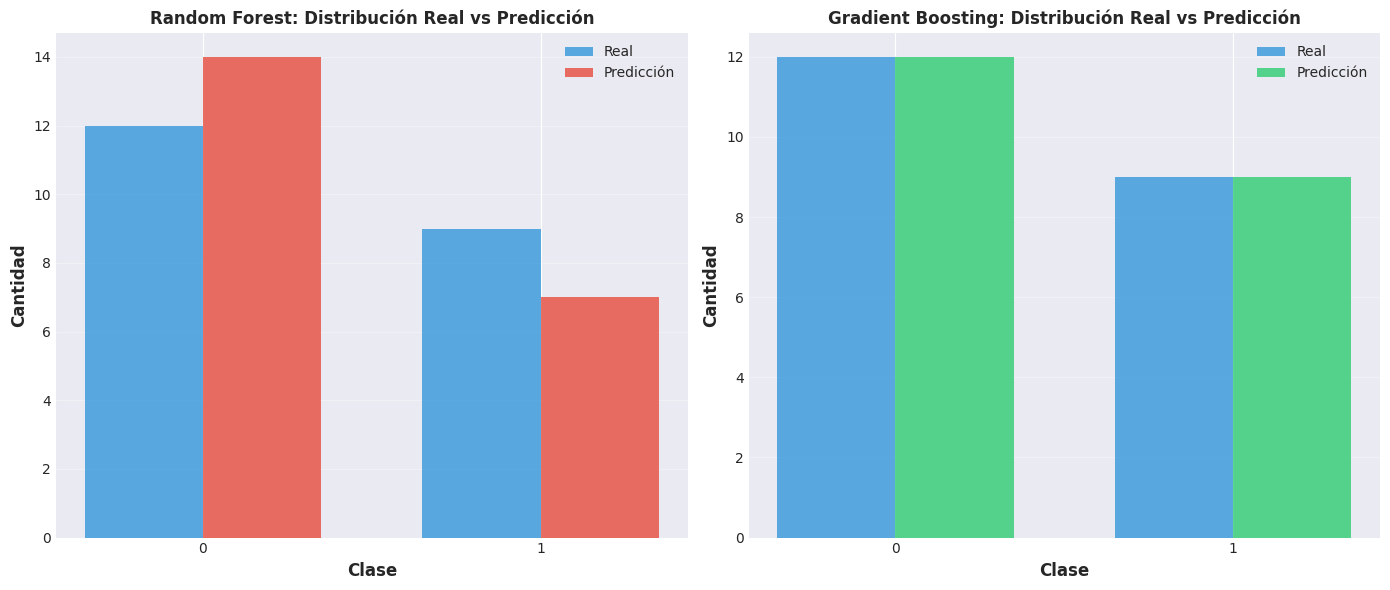

In [21]:
# PREDICCIONES VS REALES

print(f" Gráfico 4: Predicciones vs Valores Reales")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

if es_clasificacion:
    real_counts = pd.Series(y_test).value_counts().sort_index()
    pred_counts = pd.Series(y_pred_rf).value_counts().sort_index()

    x = np.arange(len(real_counts))
    width = 0.35

    axes[0].bar(x - width/2, real_counts.values, width, label='Real', color='#3498db', alpha=0.8)
    axes[0].bar(x + width/2, pred_counts.values, width, label='Predicción', color='#e74c3c', alpha=0.8)
    axes[0].set_xlabel('Clase', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Cantidad', fontsize=12, fontweight='bold')
    axes[0].set_title('Random Forest: Distribución Real vs Predicción',
                     fontsize=12, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(real_counts.index)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
else:
    axes[0].scatter(y_test, y_pred_rf, alpha=0.5, color='#3498db', s=30)
    axes[0].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', lw=2, label='Predicción Perfecta')
    axes[0].set_xlabel('Valores Reales', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Predicciones', fontsize=12, fontweight='bold')
    axes[0].set_title('Random Forest: Predicción vs Real',
                     fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

if es_clasificacion:
    pred_counts_gb = pd.Series(y_pred_gb).value_counts().sort_index()

    axes[1].bar(x - width/2, real_counts.values, width, label='Real', color='#3498db', alpha=0.8)
    axes[1].bar(x + width/2, pred_counts_gb.values, width, label='Predicción', color='#2ecc71', alpha=0.8)
    axes[1].set_xlabel('Clase', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cantidad', fontsize=12, fontweight='bold')
    axes[1].set_title('Gradient Boosting: Distribución Real vs Predicción',
                     fontsize=12, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(real_counts.index)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
else:
    axes[1].scatter(y_test, y_pred_gb, alpha=0.5, color='#2ecc71', s=30)
    axes[1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', lw=2, label='Predicción Perfecta')
    axes[1].set_xlabel('Valores Reales', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Predicciones', fontsize=12, fontweight='bold')
    axes[1].set_title('Gradient Boosting: Predicción vs Real',
                     fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predicciones_vs_real.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

 Gráfico 1: Comparación de Modelos


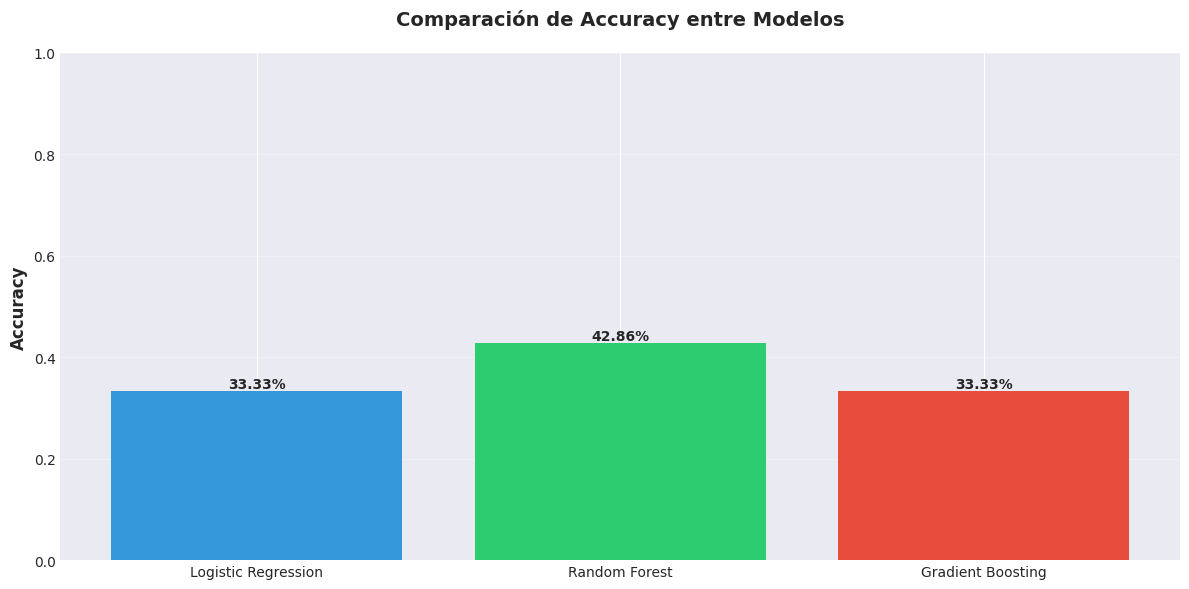

In [23]:
print(f" Gráfico 1: Comparación de Modelos")

fig, ax = plt.subplots(figsize=(12, 6))

if es_clasificacion:
    modelos_nombres = list(resultados_modelos.keys())
    accuracies = [resultados_modelos[m]['accuracy'] for m in modelos_nombres]

    bars = ax.bar(modelos_nombres, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Comparación de Accuracy entre Modelos', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom', fontweight='bold')
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    modelos_nombres = list(resultados_modelos.keys())
    rmse_values = [resultados_modelos[m]['rmse'] for m in modelos_nombres]
    r2_values = [resultados_modelos[m]['r2'] for m in modelos_nombres]

    bars1 = ax1.bar(modelos_nombres, rmse_values, color=['#2ecc71', '#e74c3c'])
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.set_title('Error (RMSE) por Modelo', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold')

    bars2 = ax2.bar(modelos_nombres, r2_values, color=['#2ecc71', '#e74c3c'])
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.set_title('R² Score por Modelo', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


 Gráfico de velas


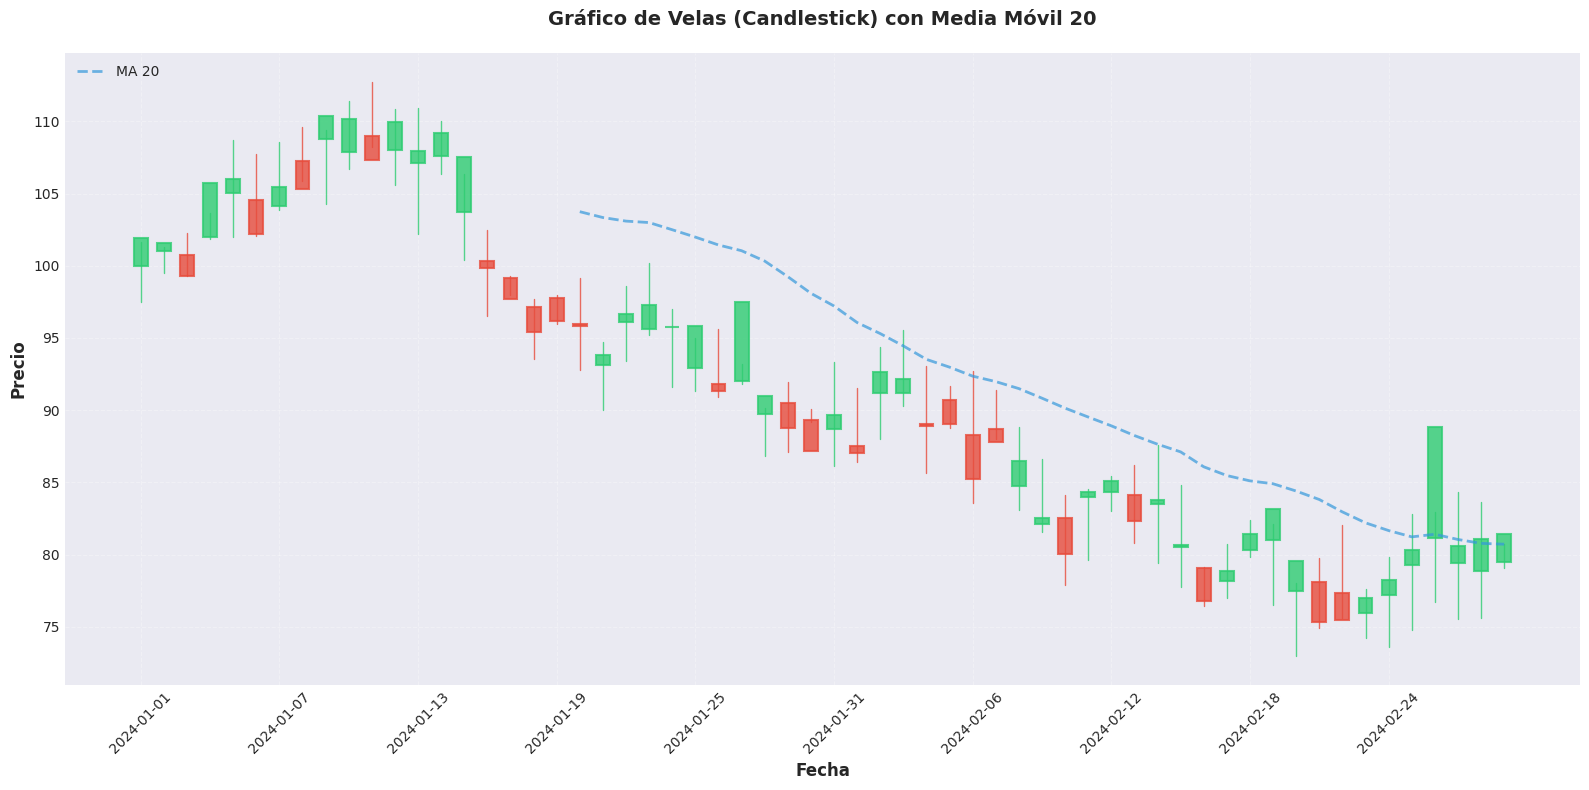

In [22]:
# VISUALIZACIÓN 5: GRÁFICO DE VELAS (CANDLESTICK)
print(f"\n Gráfico de velas")

# Crear datos para gráfico de velas
if len(columnas_fecha) > 0:
    fecha_col = columnas_fecha[0]
    df_temporal = df_clean.copy()
    df_temporal = df_temporal.sort_values(fecha_col)

    col_precio = None
    for col in df_temporal.columns:
        if any(keyword in col.lower() for keyword in ['precio', 'monto', 'valor', 'importe']):
            if df_temporal[col].dtype in ['int64', 'float64']:
                col_precio = col
                break

    if col_precio:
        df_temporal['fecha_truncada'] = df_temporal[fecha_col].dt.date

        ohlc = df_temporal.groupby('fecha_truncada')[col_precio].agg([
            ('open', 'first'),
            ('high', 'max'),
            ('low', 'min'),
            ('close', 'last')
        ]).reset_index()

        ohlc = ohlc.tail(60)
    else:

        fechas = pd.date_range(start='2024-01-01', periods=60, freq='D')
        np.random.seed(42)

        precio_inicial = 100
        precios = [precio_inicial]
        for _ in range(59):
            cambio = np.random.normal(0, 2)
            precios.append(precios[-1] + cambio)

        ohlc = pd.DataFrame({
            'fecha_truncada': fechas,
            'open': precios,
            'high': [p + np.random.uniform(0, 5) for p in precios],
            'low': [p - np.random.uniform(0, 5) for p in precios],
            'close': [p + np.random.normal(0, 2) for p in precios]
        })
else:

    fechas = pd.date_range(start='2024-01-01', periods=60, freq='D')
    np.random.seed(42)

    precio_inicial = 100
    precios = [precio_inicial]
    for _ in range(59):
        cambio = np.random.normal(0, 2)
        precios.append(precios[-1] + cambio)

    ohlc = pd.DataFrame({
        'fecha_truncada': fechas,
        'open': precios,
        'high': [p + np.random.uniform(0, 5) for p in precios],
        'low': [p - np.random.uniform(0, 5) for p in precios],
        'close': [p + np.random.normal(0, 2) for p in precios]
    })

# Crear gráfico
fig, ax = plt.subplots(figsize=(16, 8))

colors = ['#2ecc71' if close >= open_ else '#e74c3c'
          for close, open_ in zip(ohlc['close'], ohlc['open'])]

for i in range(len(ohlc)):
    ax.plot([i, i], [ohlc.iloc[i]['low'], ohlc.iloc[i]['high']],
            color=colors[i], linewidth=1, alpha=0.8)

    height = abs(ohlc.iloc[i]['close'] - ohlc.iloc[i]['open'])
    bottom = min(ohlc.iloc[i]['open'], ohlc.iloc[i]['close'])

    rect = plt.Rectangle((i - 0.3, bottom), 0.6, height,
                         facecolor=colors[i], edgecolor=colors[i],
                         alpha=0.8, linewidth=1.5)
    ax.add_patch(rect)

ma_20 = ohlc['close'].rolling(window=20).mean()
ax.plot(range(len(ohlc)), ma_20, label='MA 20', color='#3498db',
        linewidth=2, alpha=0.7, linestyle='--')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Precio', fontsize=12, fontweight='bold')
ax.set_title('Gráfico de Velas (Candlestick) con Media Móvil 20',
             fontsize=14, fontweight='bold', pad=20)

step = max(1, len(ohlc) // 10)
ax.set_xticks(range(0, len(ohlc), step))
ax.set_xticklabels([ohlc.iloc[i]['fecha_truncada'].strftime('%Y-%m-%d')
                     for i in range(0, len(ohlc), step)], rotation=45)

ax.legend(loc='upper left')
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('grafico_velas.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

PASO : CONCLUSIONES

In [20]:
# RESUMEN FINAL
print("RESUMEN FINAL DE RESULTADOS")

print(f"\n Dataset procesado:")
print(f"   Total de registros: {len(df_clean):,}")
print(f"   Features utilizadas: {X.shape[1]}")
print(f"   Variable objetivo: {target_column}")

print(f"\n Modelos entrenados:")
for nombre_modelo, resultados in resultados_modelos.items():
    print(f"\n   {nombre_modelo}:")
    if es_clasificacion:
        print(f"      Accuracy: {resultados['accuracy']:.4f} ({resultados['accuracy']*100:.2f}%)")
    else:
        print(f"      RMSE: {resultados['rmse']:.4f}")
        print(f"      R²: {resultados['r2']:.4f}")
        
print(f"\n Visualizaciones generadas:")
print(f"   1. comparacion_modelos.png")
if es_clasificacion:
    print(f"   2. matrices_confusion.png")
print(f"   3. importancia_features.png")
print(f"   4. predicciones_vs_real.png")
print(f"   5. grafico_velas.png")

RESUMEN FINAL DE RESULTADOS

 Dataset procesado:
   Total de registros: 101
   Features utilizadas: 3
   Variable objetivo: clasificacion

 Modelos entrenados:

   Logistic Regression:
      Accuracy: 0.3333 (33.33%)

   Random Forest:
      Accuracy: 0.4286 (42.86%)

   Gradient Boosting:
      Accuracy: 0.3333 (33.33%)

 Visualizaciones generadas:
   1. comparacion_modelos.png
   2. matrices_confusion.png
   3. importancia_features.png
   4. predicciones_vs_real.png
   5. grafico_velas.png


In [ ]:
print(f"\nTodo ready yayyy...PROCESO EXITOSO E'MENTIRAAAAAA")


Todo ready yayyy...PROCESO EXITOSO E'MENTIRAAAAAA
